In [1]:
from models.logit.base import get_match_result_data

df, player_mapping, inverse_player_mapping = get_match_result_data()

In [2]:
df['__surface__'].value_counts(normalize=True)

Hard      0.387642
Clay      0.324512
Indoor    0.179151
Grass     0.108696
Name: __surface__, dtype: float64

In [40]:
df.groupby(['court', 'surface']).size() / df.shape[0]

court    surface
Indoor   Carpet     0.033357
         Clay       0.003722
         Hard       0.142072
Outdoor  Clay       0.324512
         Grass      0.108696
         Hard       0.387642
dtype: float64

In [3]:
df.sort('date', inplace=True)

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


#### Build a Model for Just HardCourt

Let's tune over weights on other surfaces to get a model for just hardcourt

In [19]:
train_df = df[df['date'] < '2016-01-01'].copy()
val_df = df[
    (df['date'] >= '2016-01-01') &
    (df['date'] < '2017-01-01') &
    (df['__surface__'] == 'Hard')
].copy()

In [20]:
from models.logit.base import get_X_y

train_X, train_y = get_X_y(train_df, player_mapping)
val_X, val_y = get_X_y(val_df, player_mapping)

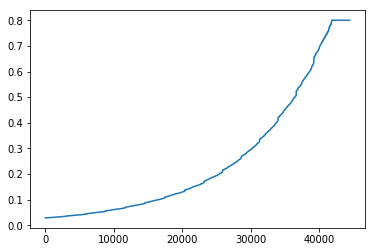

In [21]:
%matplotlib inline
from models.logit.base import sipko_weights
import pandas as pd
from matplotlib import pyplot as plt

DISCOUNT = 0.8  # Taken from Sipko paper
FLAT_TIME = 1.  # Taken from Sipko paper

s_weights = sipko_weights(train_df['date'].max(), train_df, DISCOUNT, FLAT_TIME)
plt.plot(range(len(s_weights)), s_weights)

In [22]:
import numpy as np
import itertools

clay_weights = np.linspace(0, 1, 11)
grass_weights = np.linspace(0, 1, 11)
indoor_weights = np.linspace(0, 1, 11)

tuners = list(itertools.product(*[clay_weights, grass_weights, indoor_weights]))

In [23]:
from ml.prior_logit import NonZeroLogit
from sklearn.metrics import roc_auc_score


LMBDA = 10.  # Regularize!
PRIOR = -2.

def _get_surface_weights(train_df, surface_weight_map):
    return train_df['__surface__'].map(lambda x: surface_weight_map[x])

rel_val_df = val_df[val_df['__surface__'] == 'Hard'].copy()

def _try_surface_weight(cw, gw, iw):
    surface_weight_map = {
        'Clay': cw,
        'Grass': gw,
        'Indoor': iw,
        'Hard': 1.
    }
    surface_weights = _get_surface_weights(train_df, surface_weight_map)
    sample_weights = s_weights * surface_weights
    nzl = NonZeroLogit(lmbda=LMBDA, prior=PRIOR, seed=10)
    nzl.fit(train_X, train_y, sample_weight=sample_weights)
    val_preds = nzl.predict_proba(val_X)[:, 1]
    auc = roc_auc_score(val_df['y'], val_preds)
    accuracy = (val_df['y'] == (val_preds > 0.5).astype(int)).mean()
    return auc, accuracy

In [ ]:
perfs = []
for cw, gw, iw in tuners:
    print (cw, gw, iw)
    auc, accuracy = _try_surface_weight(cw, gw, iw)
    perfs.append((cw, gw, iw, auc, accuracy))

In [ ]:
perf_df = pd.DataFrame(
    perfs,
    columns=[
        'cw',
        'gw',
        'iw',
        'auc',
        'accuracy'
    ]
)
perf_df.sort('auc', ascending=False).head(15)

In [ ]:
# Try Sipko weighting scheme to see what happens...
_try_surface_weight(0.28, 0.35, 0.24)

In [ ]:
# How do we do with original weighting scheme 
_try_surface_weight(1., 1., 1.)

In [ ]:
# Keep Hardcourt Results Around
hc_mod = NonZeroLogit(lmbda=LMBDA, prior=PRIOR)
surface_weights = _get_surface_weights(train_df, {
    'Clay': 0.6,
    'Indoor': 1.0,
    'Grass': 1.0,
    'Hard': 1.0
})
weights = s_weights * surface_weights
hc_mod.fit(train_X, train_y, sample_weight=weights)
val_df['pred'] = hc_mod.predict_proba(val_X)[:, 1]

In [ ]:
roc_auc_score(val_df['y'], val_df['pred'])

#### Build a Model for Just Clay 

In [49]:
import itertools
import numpy as np
import pandas as pd
from models.logit.base import sipko_weights, get_X_y
from ml.prior_logit import NonZeroLogit
from sklearn.metrics import roc_auc_score

N_ATTEMPTS_PER_SURFACE = 10
SURFACES = df['__surface__'].unique().tolist()
N_SURFACES = len(SURFACES) 
TUNERS = list(itertools.product(*[
    np.linspace(0., 1., N_ATTEMPTS_PER_SURFACE + 1) for _ in range(N_SURFACES - 1)
]))
DISCOUNT = 0.8  # Taken from Sipko paper
FLAT_TIME = 1.  # Taken from Sipko paper
LMBDA = 10.  # Regularize!
PRIOR = -2.


def _get_surface_weights(train_df, surface_weight_map):
    return train_df['__surface__'].map(lambda x: surface_weight_map[x])


def try_surface_weights(train_df, sw_map, val_df, sipko_weighting):
    surface_weights = _get_surface_weights(train_df, sw_map)
    sample_weights = sipko_weighting * surface_weights
    nzl = NonZeroLogit(lmbda=LMBDA, prior=PRIOR, seed=10)
    nzl.fit(train_X, train_y, sample_weight=sample_weights)
    val_preds = nzl.predict_proba(val_X)[:, 1]
    auc = roc_auc_score(val_df['y'], val_preds)
    accuracy = (val_df['y'] == (val_preds > 0.5).astype(int)).mean()
    return auc, accuracy


def tune_weights_for_surface(surface):
    # Get data
    train_df = df[
        (df['date'] < '2016-01-01') 
    ].copy()
    train_X, train_y = get_X_y(train_df, player_mapping)
    val_df = df[
        (df['date'] >= '2016-01-01') &
        (df['date'] < '2017-01-01') &
        (df['__surface__'] == surface)
    ].copy()
    val_X, val_y = get_X_y(val_df, player_mapping)
    s_weights = sipko_weights(train_df['date'].max(), train_df, DISCOUNT, flat_time=FLAT_TIME)
    
    tune_surfaces = sorted([x for x in SURFACES if x != surface])

    perfs = []
    for weights in TUNERS:
        sw_map = dict(zip(tune_surfaces, weights))
        sw_map.update({surface: 1.})
        print sw_map
        surface_weights = _get_surface_weights(train_df, sw_map)
        sample_weights = s_weights * surface_weights

        nzl = NonZeroLogit(lmbda=LMBDA, prior=PRIOR, seed=10)
        nzl.fit(train_X, train_y, sample_weight=sample_weights)

        val_preds = nzl.predict_proba(val_X)[:, 1]
        auc = roc_auc_score(val_df['y'], val_preds)
        accuracy = (val_df['y'] == (val_preds > 0.5).astype(int)).mean()

        _record = list(weights)
        _record.extend([auc, accuracy])
        perfs.append(_record)
    return pd.DataFrame(
        perfs,
        columns=tune_surfaces + ['auc', 'accuracy']
    )

In [25]:
hard_results = tune_weights_for_surface('Hard')

{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 0.0, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 0.10000000000000001, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 0.20000000000000001, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 0.30000000000000004, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 0.40000000000000002, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 0.5, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 0.60000000000000009, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 0.70000000000000007, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 0.80000000000000004, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 0.90000000000000002, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 0.0, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 0.10000000000000001, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 0.20000000000000001, 'Clay': 0.0}
{'Hard':

{'Hard': 1.0, 'Grass': 0.90000000000000002, 'Indoor': 0.40000000000000002, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.90000000000000002, 'Indoor': 0.5, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.90000000000000002, 'Indoor': 0.60000000000000009, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.90000000000000002, 'Indoor': 0.70000000000000007, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.90000000000000002, 'Indoor': 0.80000000000000004, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.90000000000000002, 'Indoor': 0.90000000000000002, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 1.0, 'Indoor': 0.0, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 1.0, 'Indoor': 0.10000000000000001, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 1.0, 'Indoor': 0.20000000000000001, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 1.0, 'Indoor': 0.30000000000000004, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 1.0, 'Indoor': 0.40000000000000002, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 1.0, 'Indoor': 0.5, 'Clay': 0.0}
{'Hard': 1.0, 'G

{'Hard': 1.0, 'Grass': 0.60000000000000009, 'Indoor': 0.80000000000000004, 'Clay': 0.10000000000000001}
{'Hard': 1.0, 'Grass': 0.60000000000000009, 'Indoor': 0.90000000000000002, 'Clay': 0.10000000000000001}
{'Hard': 1.0, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 0.10000000000000001}
{'Hard': 1.0, 'Grass': 0.70000000000000007, 'Indoor': 0.0, 'Clay': 0.10000000000000001}
{'Hard': 1.0, 'Grass': 0.70000000000000007, 'Indoor': 0.10000000000000001, 'Clay': 0.10000000000000001}
{'Hard': 1.0, 'Grass': 0.70000000000000007, 'Indoor': 0.20000000000000001, 'Clay': 0.10000000000000001}
{'Hard': 1.0, 'Grass': 0.70000000000000007, 'Indoor': 0.30000000000000004, 'Clay': 0.10000000000000001}
{'Hard': 1.0, 'Grass': 0.70000000000000007, 'Indoor': 0.40000000000000002, 'Clay': 0.10000000000000001}
{'Hard': 1.0, 'Grass': 0.70000000000000007, 'Indoor': 0.5, 'Clay': 0.10000000000000001}
{'Hard': 1.0, 'Grass': 0.70000000000000007, 'Indoor': 0.60000000000000009, 'Clay': 0.10000000000000001}
{'Hard':

{'Hard': 1.0, 'Grass': 0.30000000000000004, 'Indoor': 0.70000000000000007, 'Clay': 0.20000000000000001}
{'Hard': 1.0, 'Grass': 0.30000000000000004, 'Indoor': 0.80000000000000004, 'Clay': 0.20000000000000001}
{'Hard': 1.0, 'Grass': 0.30000000000000004, 'Indoor': 0.90000000000000002, 'Clay': 0.20000000000000001}
{'Hard': 1.0, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.20000000000000001}
{'Hard': 1.0, 'Grass': 0.40000000000000002, 'Indoor': 0.0, 'Clay': 0.20000000000000001}
{'Hard': 1.0, 'Grass': 0.40000000000000002, 'Indoor': 0.10000000000000001, 'Clay': 0.20000000000000001}
{'Hard': 1.0, 'Grass': 0.40000000000000002, 'Indoor': 0.20000000000000001, 'Clay': 0.20000000000000001}
{'Hard': 1.0, 'Grass': 0.40000000000000002, 'Indoor': 0.30000000000000004, 'Clay': 0.20000000000000001}
{'Hard': 1.0, 'Grass': 0.40000000000000002, 'Indoor': 0.40000000000000002, 'Clay': 0.20000000000000001}
{'Hard': 1.0, 'Grass': 0.40000000000000002, 'Indoor': 0.5, 'Clay': 0.20000000000000001}
{'Hard':

{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 0.70000000000000007, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 0.80000000000000004, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 0.90000000000000002, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 0.0, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 0.10000000000000001, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 0.20000000000000001, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 0.30000000000000004, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 0.40000000000000002, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 0.5, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 0.6000000000000000

{'Hard': 1.0, 'Grass': 0.80000000000000004, 'Indoor': 0.40000000000000002, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.80000000000000004, 'Indoor': 0.5, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.80000000000000004, 'Indoor': 0.60000000000000009, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.80000000000000004, 'Indoor': 0.70000000000000007, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.80000000000000004, 'Indoor': 0.80000000000000004, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.80000000000000004, 'Indoor': 0.90000000000000002, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.80000000000000004, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.90000000000000002, 'Indoor': 0.0, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.90000000000000002, 'Indoor': 0.10000000000000001, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.90000000000000002, 'Indoor': 0.20000000000000001, 'Clay': 0.30000000000000004}
{'Hard':

{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 0.30000000000000004, 'Clay': 0.40000000000000002}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 0.40000000000000002, 'Clay': 0.40000000000000002}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 0.5, 'Clay': 0.40000000000000002}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 0.60000000000000009, 'Clay': 0.40000000000000002}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 0.70000000000000007, 'Clay': 0.40000000000000002}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 0.80000000000000004, 'Clay': 0.40000000000000002}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 0.90000000000000002, 'Clay': 0.40000000000000002}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 1.0, 'Clay': 0.40000000000000002}
{'Hard': 1.0, 'Grass': 0.60000000000000009, 'Indoor': 0.0, 'Clay': 0.40000000000000002}
{'Hard': 1.0, 'Grass': 0.60000000000000009, 'Indoor': 0.10000000000000001, 'Clay': 0.40000000000000002}
{'Hard': 1.0, 'Grass': 0.60000000000000009, 'Indoor': 0.20000000000000001, 'Clay': 0.40000000000000002}
{'Hard': 1.0, 'Grass': 0.6000000

{'Hard': 1.0, 'Grass': 0.20000000000000001, 'Indoor': 0.80000000000000004, 'Clay': 0.5}
{'Hard': 1.0, 'Grass': 0.20000000000000001, 'Indoor': 0.90000000000000002, 'Clay': 0.5}
{'Hard': 1.0, 'Grass': 0.20000000000000001, 'Indoor': 1.0, 'Clay': 0.5}
{'Hard': 1.0, 'Grass': 0.30000000000000004, 'Indoor': 0.0, 'Clay': 0.5}
{'Hard': 1.0, 'Grass': 0.30000000000000004, 'Indoor': 0.10000000000000001, 'Clay': 0.5}
{'Hard': 1.0, 'Grass': 0.30000000000000004, 'Indoor': 0.20000000000000001, 'Clay': 0.5}
{'Hard': 1.0, 'Grass': 0.30000000000000004, 'Indoor': 0.30000000000000004, 'Clay': 0.5}
{'Hard': 1.0, 'Grass': 0.30000000000000004, 'Indoor': 0.40000000000000002, 'Clay': 0.5}
{'Hard': 1.0, 'Grass': 0.30000000000000004, 'Indoor': 0.5, 'Clay': 0.5}
{'Hard': 1.0, 'Grass': 0.30000000000000004, 'Indoor': 0.60000000000000009, 'Clay': 0.5}
{'Hard': 1.0, 'Grass': 0.30000000000000004, 'Indoor': 0.70000000000000007, 'Clay': 0.5}
{'Hard': 1.0, 'Grass': 0.30000000000000004, 'Indoor': 0.80000000000000004, 'Clay

{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 0.10000000000000001, 'Clay': 0.60000000000000009}
{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 0.20000000000000001, 'Clay': 0.60000000000000009}
{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 0.30000000000000004, 'Clay': 0.60000000000000009}
{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 0.40000000000000002, 'Clay': 0.60000000000000009}
{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 0.5, 'Clay': 0.60000000000000009}
{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 0.60000000000000009, 'Clay': 0.60000000000000009}
{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 0.70000000000000007, 'Clay': 0.60000000000000009}
{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 0.80000000000000004, 'Clay': 0.60000000000000009}
{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 0.90000000000000002, 'Clay': 0.60000000000000009}
{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 0.60000000000

{'Hard': 1.0, 'Grass': 0.80000000000000004, 'Indoor': 0.80000000000000004, 'Clay': 0.60000000000000009}
{'Hard': 1.0, 'Grass': 0.80000000000000004, 'Indoor': 0.90000000000000002, 'Clay': 0.60000000000000009}
{'Hard': 1.0, 'Grass': 0.80000000000000004, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard': 1.0, 'Grass': 0.90000000000000002, 'Indoor': 0.0, 'Clay': 0.60000000000000009}
{'Hard': 1.0, 'Grass': 0.90000000000000002, 'Indoor': 0.10000000000000001, 'Clay': 0.60000000000000009}
{'Hard': 1.0, 'Grass': 0.90000000000000002, 'Indoor': 0.20000000000000001, 'Clay': 0.60000000000000009}
{'Hard': 1.0, 'Grass': 0.90000000000000002, 'Indoor': 0.30000000000000004, 'Clay': 0.60000000000000009}
{'Hard': 1.0, 'Grass': 0.90000000000000002, 'Indoor': 0.40000000000000002, 'Clay': 0.60000000000000009}
{'Hard': 1.0, 'Grass': 0.90000000000000002, 'Indoor': 0.5, 'Clay': 0.60000000000000009}
{'Hard': 1.0, 'Grass': 0.90000000000000002, 'Indoor': 0.60000000000000009, 'Clay': 0.60000000000000009}
{'Hard':

{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 0.80000000000000004, 'Clay': 0.70000000000000007}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 0.90000000000000002, 'Clay': 0.70000000000000007}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 1.0, 'Clay': 0.70000000000000007}
{'Hard': 1.0, 'Grass': 0.60000000000000009, 'Indoor': 0.0, 'Clay': 0.70000000000000007}
{'Hard': 1.0, 'Grass': 0.60000000000000009, 'Indoor': 0.10000000000000001, 'Clay': 0.70000000000000007}
{'Hard': 1.0, 'Grass': 0.60000000000000009, 'Indoor': 0.20000000000000001, 'Clay': 0.70000000000000007}
{'Hard': 1.0, 'Grass': 0.60000000000000009, 'Indoor': 0.30000000000000004, 'Clay': 0.70000000000000007}
{'Hard': 1.0, 'Grass': 0.60000000000000009, 'Indoor': 0.40000000000000002, 'Clay': 0.70000000000000007}
{'Hard': 1.0, 'Grass': 0.60000000000000009, 'Indoor': 0.5, 'Clay': 0.70000000000000007}
{'Hard': 1.0, 'Grass': 0.60000000000000009, 'Indoor': 0.60000000000000009, 'Clay': 0.70000000000000007}
{'Hard': 1.0, 'Grass': 0.60000000000000009, 'Indoor': 0.

{'Hard': 1.0, 'Grass': 0.20000000000000001, 'Indoor': 0.70000000000000007, 'Clay': 0.80000000000000004}
{'Hard': 1.0, 'Grass': 0.20000000000000001, 'Indoor': 0.80000000000000004, 'Clay': 0.80000000000000004}
{'Hard': 1.0, 'Grass': 0.20000000000000001, 'Indoor': 0.90000000000000002, 'Clay': 0.80000000000000004}
{'Hard': 1.0, 'Grass': 0.20000000000000001, 'Indoor': 1.0, 'Clay': 0.80000000000000004}
{'Hard': 1.0, 'Grass': 0.30000000000000004, 'Indoor': 0.0, 'Clay': 0.80000000000000004}
{'Hard': 1.0, 'Grass': 0.30000000000000004, 'Indoor': 0.10000000000000001, 'Clay': 0.80000000000000004}
{'Hard': 1.0, 'Grass': 0.30000000000000004, 'Indoor': 0.20000000000000001, 'Clay': 0.80000000000000004}
{'Hard': 1.0, 'Grass': 0.30000000000000004, 'Indoor': 0.30000000000000004, 'Clay': 0.80000000000000004}
{'Hard': 1.0, 'Grass': 0.30000000000000004, 'Indoor': 0.40000000000000002, 'Clay': 0.80000000000000004}
{'Hard': 1.0, 'Grass': 0.30000000000000004, 'Indoor': 0.5, 'Clay': 0.80000000000000004}
{'Hard':

{'Hard': 1.0, 'Grass': 1.0, 'Indoor': 0.40000000000000002, 'Clay': 0.80000000000000004}
{'Hard': 1.0, 'Grass': 1.0, 'Indoor': 0.5, 'Clay': 0.80000000000000004}
{'Hard': 1.0, 'Grass': 1.0, 'Indoor': 0.60000000000000009, 'Clay': 0.80000000000000004}
{'Hard': 1.0, 'Grass': 1.0, 'Indoor': 0.70000000000000007, 'Clay': 0.80000000000000004}
{'Hard': 1.0, 'Grass': 1.0, 'Indoor': 0.80000000000000004, 'Clay': 0.80000000000000004}
{'Hard': 1.0, 'Grass': 1.0, 'Indoor': 0.90000000000000002, 'Clay': 0.80000000000000004}
{'Hard': 1.0, 'Grass': 1.0, 'Indoor': 1.0, 'Clay': 0.80000000000000004}
{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 0.0, 'Clay': 0.90000000000000002}
{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 0.10000000000000001, 'Clay': 0.90000000000000002}
{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 0.20000000000000001, 'Clay': 0.90000000000000002}
{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 0.30000000000000004, 'Clay': 0.90000000000000002}
{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 0.40000000000000002, 'Clay': 0.90000000000

{'Hard': 1.0, 'Grass': 0.70000000000000007, 'Indoor': 0.30000000000000004, 'Clay': 0.90000000000000002}
{'Hard': 1.0, 'Grass': 0.70000000000000007, 'Indoor': 0.40000000000000002, 'Clay': 0.90000000000000002}
{'Hard': 1.0, 'Grass': 0.70000000000000007, 'Indoor': 0.5, 'Clay': 0.90000000000000002}
{'Hard': 1.0, 'Grass': 0.70000000000000007, 'Indoor': 0.60000000000000009, 'Clay': 0.90000000000000002}
{'Hard': 1.0, 'Grass': 0.70000000000000007, 'Indoor': 0.70000000000000007, 'Clay': 0.90000000000000002}
{'Hard': 1.0, 'Grass': 0.70000000000000007, 'Indoor': 0.80000000000000004, 'Clay': 0.90000000000000002}
{'Hard': 1.0, 'Grass': 0.70000000000000007, 'Indoor': 0.90000000000000002, 'Clay': 0.90000000000000002}
{'Hard': 1.0, 'Grass': 0.70000000000000007, 'Indoor': 1.0, 'Clay': 0.90000000000000002}
{'Hard': 1.0, 'Grass': 0.80000000000000004, 'Indoor': 0.0, 'Clay': 0.90000000000000002}
{'Hard': 1.0, 'Grass': 0.80000000000000004, 'Indoor': 0.10000000000000001, 'Clay': 0.90000000000000002}
{'Hard':

{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 0.0, 'Clay': 1.0}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 0.10000000000000001, 'Clay': 1.0}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 0.20000000000000001, 'Clay': 1.0}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 0.30000000000000004, 'Clay': 1.0}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 0.40000000000000002, 'Clay': 1.0}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 0.5, 'Clay': 1.0}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 0.60000000000000009, 'Clay': 1.0}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 0.70000000000000007, 'Clay': 1.0}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 0.80000000000000004, 'Clay': 1.0}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 0.90000000000000002, 'Clay': 1.0}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 1.0, 'Clay': 1.0}
{'Hard': 1.0, 'Grass': 0.60000000000000009, 'Indoor': 0.0, 'Clay': 1.0}
{'Hard': 1.0, 'Grass': 0.60000000000000009, 'Indoor': 0.10000000000000001, 'Clay': 1.0}
{'Hard': 1.0, 'Grass': 0.60000000000000009, 'Indoor': 0.20000000000000001, 'Clay': 1.0}
{'Hard':

In [28]:
hard_results.sort('auc', ascending=False).head()

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


,Clay,Grass,Indoor,auc,accuracy
966,0.7,1.0,0.9,0.735645,0.668778
965,0.7,1.0,0.8,0.735600,0.672398
843,0.6,1.0,0.7,0.735511,0.675113
1209,0.9,1.0,1.0,0.735495,0.667873
845,0.6,1.0,0.9,0.735478,0.667873


In [32]:
clay_results = tune_weights_for_surface('Clay')

{'Grass': 0.0, 'Indoor': 0.0, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.0, 'Indoor': 0.10000000000000001, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.0, 'Indoor': 0.20000000000000001, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.0, 'Indoor': 0.30000000000000004, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.0, 'Indoor': 0.40000000000000002, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.0, 'Indoor': 0.5, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.0, 'Indoor': 0.60000000000000009, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.0, 'Indoor': 0.70000000000000007, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.0, 'Indoor': 0.80000000000000004, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.0, 'Indoor': 0.90000000000000002, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.0, 'Indoor': 1.0, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.0, 'Indoor': 0.0, 'Clay': 1.0, 'Hard': 0.10000000000000001}
{'Grass': 0.0, 'Indoor': 0.10000000000000001, 'Clay': 1.0, 'Hard': 0.10000000000000001}
{'Grass': 0.0, 'Indoor': 0.20000000000000001, 'Clay': 1.0, 'Hard': 0.10000000000000001}
{'Grass'

{'Grass': 0.0, 'Indoor': 0.5, 'Clay': 1.0, 'Hard': 0.90000000000000002}
{'Grass': 0.0, 'Indoor': 0.60000000000000009, 'Clay': 1.0, 'Hard': 0.90000000000000002}
{'Grass': 0.0, 'Indoor': 0.70000000000000007, 'Clay': 1.0, 'Hard': 0.90000000000000002}
{'Grass': 0.0, 'Indoor': 0.80000000000000004, 'Clay': 1.0, 'Hard': 0.90000000000000002}
{'Grass': 0.0, 'Indoor': 0.90000000000000002, 'Clay': 1.0, 'Hard': 0.90000000000000002}
{'Grass': 0.0, 'Indoor': 1.0, 'Clay': 1.0, 'Hard': 0.90000000000000002}
{'Grass': 0.0, 'Indoor': 0.0, 'Clay': 1.0, 'Hard': 1.0}
{'Grass': 0.0, 'Indoor': 0.10000000000000001, 'Clay': 1.0, 'Hard': 1.0}
{'Grass': 0.0, 'Indoor': 0.20000000000000001, 'Clay': 1.0, 'Hard': 1.0}
{'Grass': 0.0, 'Indoor': 0.30000000000000004, 'Clay': 1.0, 'Hard': 1.0}
{'Grass': 0.0, 'Indoor': 0.40000000000000002, 'Clay': 1.0, 'Hard': 1.0}
{'Grass': 0.0, 'Indoor': 0.5, 'Clay': 1.0, 'Hard': 1.0}
{'Grass': 0.0, 'Indoor': 0.60000000000000009, 'Clay': 1.0, 'Hard': 1.0}
{'Grass': 0.0, 'Indoor': 0.70000

{'Grass': 0.10000000000000001, 'Indoor': 0.80000000000000004, 'Clay': 1.0, 'Hard': 0.60000000000000009}
{'Grass': 0.10000000000000001, 'Indoor': 0.90000000000000002, 'Clay': 1.0, 'Hard': 0.60000000000000009}
{'Grass': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 1.0, 'Hard': 0.60000000000000009}
{'Grass': 0.10000000000000001, 'Indoor': 0.0, 'Clay': 1.0, 'Hard': 0.70000000000000007}
{'Grass': 0.10000000000000001, 'Indoor': 0.10000000000000001, 'Clay': 1.0, 'Hard': 0.70000000000000007}
{'Grass': 0.10000000000000001, 'Indoor': 0.20000000000000001, 'Clay': 1.0, 'Hard': 0.70000000000000007}
{'Grass': 0.10000000000000001, 'Indoor': 0.30000000000000004, 'Clay': 1.0, 'Hard': 0.70000000000000007}
{'Grass': 0.10000000000000001, 'Indoor': 0.40000000000000002, 'Clay': 1.0, 'Hard': 0.70000000000000007}
{'Grass': 0.10000000000000001, 'Indoor': 0.5, 'Clay': 1.0, 'Hard': 0.70000000000000007}
{'Grass': 0.10000000000000001, 'Indoor': 0.60000000000000009, 'Clay': 1.0, 'Hard': 0.70000000000000007}
{'Grass'

{'Grass': 0.20000000000000001, 'Indoor': 0.70000000000000007, 'Clay': 1.0, 'Hard': 0.30000000000000004}
{'Grass': 0.20000000000000001, 'Indoor': 0.80000000000000004, 'Clay': 1.0, 'Hard': 0.30000000000000004}
{'Grass': 0.20000000000000001, 'Indoor': 0.90000000000000002, 'Clay': 1.0, 'Hard': 0.30000000000000004}
{'Grass': 0.20000000000000001, 'Indoor': 1.0, 'Clay': 1.0, 'Hard': 0.30000000000000004}
{'Grass': 0.20000000000000001, 'Indoor': 0.0, 'Clay': 1.0, 'Hard': 0.40000000000000002}
{'Grass': 0.20000000000000001, 'Indoor': 0.10000000000000001, 'Clay': 1.0, 'Hard': 0.40000000000000002}
{'Grass': 0.20000000000000001, 'Indoor': 0.20000000000000001, 'Clay': 1.0, 'Hard': 0.40000000000000002}
{'Grass': 0.20000000000000001, 'Indoor': 0.30000000000000004, 'Clay': 1.0, 'Hard': 0.40000000000000002}
{'Grass': 0.20000000000000001, 'Indoor': 0.40000000000000002, 'Clay': 1.0, 'Hard': 0.40000000000000002}
{'Grass': 0.20000000000000001, 'Indoor': 0.5, 'Clay': 1.0, 'Hard': 0.40000000000000002}
{'Grass'

{'Grass': 0.30000000000000004, 'Indoor': 0.60000000000000009, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.30000000000000004, 'Indoor': 0.70000000000000007, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.30000000000000004, 'Indoor': 0.80000000000000004, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.30000000000000004, 'Indoor': 0.90000000000000002, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.30000000000000004, 'Indoor': 0.0, 'Clay': 1.0, 'Hard': 0.10000000000000001}
{'Grass': 0.30000000000000004, 'Indoor': 0.10000000000000001, 'Clay': 1.0, 'Hard': 0.10000000000000001}
{'Grass': 0.30000000000000004, 'Indoor': 0.20000000000000001, 'Clay': 1.0, 'Hard': 0.10000000000000001}
{'Grass': 0.30000000000000004, 'Indoor': 0.30000000000000004, 'Clay': 1.0, 'Hard': 0.10000000000000001}
{'Grass': 0.30000000000000004, 'Indoor': 0.40000000000000002, 'Clay': 1.0, 'Hard': 0.10000000000000001}
{'Grass': 0.30000000000000004, 'Indoor': 0.5, 'Clay': 1.0, 'Hard': 0.100

{'Grass': 0.30000000000000004, 'Indoor': 0.40000000000000002, 'Clay': 1.0, 'Hard': 0.80000000000000004}
{'Grass': 0.30000000000000004, 'Indoor': 0.5, 'Clay': 1.0, 'Hard': 0.80000000000000004}
{'Grass': 0.30000000000000004, 'Indoor': 0.60000000000000009, 'Clay': 1.0, 'Hard': 0.80000000000000004}
{'Grass': 0.30000000000000004, 'Indoor': 0.70000000000000007, 'Clay': 1.0, 'Hard': 0.80000000000000004}
{'Grass': 0.30000000000000004, 'Indoor': 0.80000000000000004, 'Clay': 1.0, 'Hard': 0.80000000000000004}
{'Grass': 0.30000000000000004, 'Indoor': 0.90000000000000002, 'Clay': 1.0, 'Hard': 0.80000000000000004}
{'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 1.0, 'Hard': 0.80000000000000004}
{'Grass': 0.30000000000000004, 'Indoor': 0.0, 'Clay': 1.0, 'Hard': 0.90000000000000002}
{'Grass': 0.30000000000000004, 'Indoor': 0.10000000000000001, 'Clay': 1.0, 'Hard': 0.90000000000000002}
{'Grass': 0.30000000000000004, 'Indoor': 0.20000000000000001, 'Clay': 1.0, 'Hard': 0.90000000000000002}
{'Grass'

{'Grass': 0.40000000000000002, 'Indoor': 0.30000000000000004, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 0.40000000000000002, 'Indoor': 0.40000000000000002, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 0.40000000000000002, 'Indoor': 0.5, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 0.40000000000000002, 'Indoor': 0.60000000000000009, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 0.40000000000000002, 'Indoor': 0.70000000000000007, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 0.40000000000000002, 'Indoor': 0.80000000000000004, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 0.40000000000000002, 'Indoor': 0.90000000000000002, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 0.40000000000000002, 'Indoor': 1.0, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 0.40000000000000002, 'Indoor': 0.0, 'Clay': 1.0, 'Hard': 0.60000000000000009}
{'Grass': 0.40000000000000002, 'Indoor': 0.10000000000000001, 'Clay': 1.0, 'Hard': 0.60000000000000009}
{'Grass': 0.40000000000000002, 'Indoor': 0.20000000000000001, 'Clay': 1.0, 'Hard': 0.60000000000000009}
{'Grass': 0.40000000000000002, '

{'Grass': 0.5, 'Indoor': 0.70000000000000007, 'Clay': 1.0, 'Hard': 0.20000000000000001}
{'Grass': 0.5, 'Indoor': 0.80000000000000004, 'Clay': 1.0, 'Hard': 0.20000000000000001}
{'Grass': 0.5, 'Indoor': 0.90000000000000002, 'Clay': 1.0, 'Hard': 0.20000000000000001}
{'Grass': 0.5, 'Indoor': 1.0, 'Clay': 1.0, 'Hard': 0.20000000000000001}
{'Grass': 0.5, 'Indoor': 0.0, 'Clay': 1.0, 'Hard': 0.30000000000000004}
{'Grass': 0.5, 'Indoor': 0.10000000000000001, 'Clay': 1.0, 'Hard': 0.30000000000000004}
{'Grass': 0.5, 'Indoor': 0.20000000000000001, 'Clay': 1.0, 'Hard': 0.30000000000000004}
{'Grass': 0.5, 'Indoor': 0.30000000000000004, 'Clay': 1.0, 'Hard': 0.30000000000000004}
{'Grass': 0.5, 'Indoor': 0.40000000000000002, 'Clay': 1.0, 'Hard': 0.30000000000000004}
{'Grass': 0.5, 'Indoor': 0.5, 'Clay': 1.0, 'Hard': 0.30000000000000004}
{'Grass': 0.5, 'Indoor': 0.60000000000000009, 'Clay': 1.0, 'Hard': 0.30000000000000004}
{'Grass': 0.5, 'Indoor': 0.70000000000000007, 'Clay': 1.0, 'Hard': 0.30000000000

{'Grass': 0.60000000000000009, 'Indoor': 0.0, 'Clay': 1.0, 'Hard': 0.10000000000000001}
{'Grass': 0.60000000000000009, 'Indoor': 0.10000000000000001, 'Clay': 1.0, 'Hard': 0.10000000000000001}
{'Grass': 0.60000000000000009, 'Indoor': 0.20000000000000001, 'Clay': 1.0, 'Hard': 0.10000000000000001}
{'Grass': 0.60000000000000009, 'Indoor': 0.30000000000000004, 'Clay': 1.0, 'Hard': 0.10000000000000001}
{'Grass': 0.60000000000000009, 'Indoor': 0.40000000000000002, 'Clay': 1.0, 'Hard': 0.10000000000000001}
{'Grass': 0.60000000000000009, 'Indoor': 0.5, 'Clay': 1.0, 'Hard': 0.10000000000000001}
{'Grass': 0.60000000000000009, 'Indoor': 0.60000000000000009, 'Clay': 1.0, 'Hard': 0.10000000000000001}
{'Grass': 0.60000000000000009, 'Indoor': 0.70000000000000007, 'Clay': 1.0, 'Hard': 0.10000000000000001}
{'Grass': 0.60000000000000009, 'Indoor': 0.80000000000000004, 'Clay': 1.0, 'Hard': 0.10000000000000001}
{'Grass': 0.60000000000000009, 'Indoor': 0.90000000000000002, 'Clay': 1.0, 'Hard': 0.10000000000

{'Grass': 0.60000000000000009, 'Indoor': 0.80000000000000004, 'Clay': 1.0, 'Hard': 0.80000000000000004}
{'Grass': 0.60000000000000009, 'Indoor': 0.90000000000000002, 'Clay': 1.0, 'Hard': 0.80000000000000004}
{'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 1.0, 'Hard': 0.80000000000000004}
{'Grass': 0.60000000000000009, 'Indoor': 0.0, 'Clay': 1.0, 'Hard': 0.90000000000000002}
{'Grass': 0.60000000000000009, 'Indoor': 0.10000000000000001, 'Clay': 1.0, 'Hard': 0.90000000000000002}
{'Grass': 0.60000000000000009, 'Indoor': 0.20000000000000001, 'Clay': 1.0, 'Hard': 0.90000000000000002}
{'Grass': 0.60000000000000009, 'Indoor': 0.30000000000000004, 'Clay': 1.0, 'Hard': 0.90000000000000002}
{'Grass': 0.60000000000000009, 'Indoor': 0.40000000000000002, 'Clay': 1.0, 'Hard': 0.90000000000000002}
{'Grass': 0.60000000000000009, 'Indoor': 0.5, 'Clay': 1.0, 'Hard': 0.90000000000000002}
{'Grass': 0.60000000000000009, 'Indoor': 0.60000000000000009, 'Clay': 1.0, 'Hard': 0.90000000000000002}
{'Grass'

{'Grass': 0.70000000000000007, 'Indoor': 0.70000000000000007, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 0.70000000000000007, 'Indoor': 0.80000000000000004, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 0.70000000000000007, 'Indoor': 0.90000000000000002, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 0.70000000000000007, 'Indoor': 1.0, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 0.70000000000000007, 'Indoor': 0.0, 'Clay': 1.0, 'Hard': 0.60000000000000009}
{'Grass': 0.70000000000000007, 'Indoor': 0.10000000000000001, 'Clay': 1.0, 'Hard': 0.60000000000000009}
{'Grass': 0.70000000000000007, 'Indoor': 0.20000000000000001, 'Clay': 1.0, 'Hard': 0.60000000000000009}
{'Grass': 0.70000000000000007, 'Indoor': 0.30000000000000004, 'Clay': 1.0, 'Hard': 0.60000000000000009}
{'Grass': 0.70000000000000007, 'Indoor': 0.40000000000000002, 'Clay': 1.0, 'Hard': 0.60000000000000009}
{'Grass': 0.70000000000000007, 'Indoor': 0.5, 'Clay': 1.0, 'Hard': 0.60000000000000009}
{'Grass': 0.70000000000000007, 'Indoor': 0.60000000000000009, 'Clay': 1.

{'Grass': 0.80000000000000004, 'Indoor': 0.70000000000000007, 'Clay': 1.0, 'Hard': 0.20000000000000001}
{'Grass': 0.80000000000000004, 'Indoor': 0.80000000000000004, 'Clay': 1.0, 'Hard': 0.20000000000000001}
{'Grass': 0.80000000000000004, 'Indoor': 0.90000000000000002, 'Clay': 1.0, 'Hard': 0.20000000000000001}
{'Grass': 0.80000000000000004, 'Indoor': 1.0, 'Clay': 1.0, 'Hard': 0.20000000000000001}
{'Grass': 0.80000000000000004, 'Indoor': 0.0, 'Clay': 1.0, 'Hard': 0.30000000000000004}
{'Grass': 0.80000000000000004, 'Indoor': 0.10000000000000001, 'Clay': 1.0, 'Hard': 0.30000000000000004}
{'Grass': 0.80000000000000004, 'Indoor': 0.20000000000000001, 'Clay': 1.0, 'Hard': 0.30000000000000004}
{'Grass': 0.80000000000000004, 'Indoor': 0.30000000000000004, 'Clay': 1.0, 'Hard': 0.30000000000000004}
{'Grass': 0.80000000000000004, 'Indoor': 0.40000000000000002, 'Clay': 1.0, 'Hard': 0.30000000000000004}
{'Grass': 0.80000000000000004, 'Indoor': 0.5, 'Clay': 1.0, 'Hard': 0.30000000000000004}
{'Grass'

{'Grass': 0.80000000000000004, 'Indoor': 0.5, 'Clay': 1.0, 'Hard': 1.0}
{'Grass': 0.80000000000000004, 'Indoor': 0.60000000000000009, 'Clay': 1.0, 'Hard': 1.0}
{'Grass': 0.80000000000000004, 'Indoor': 0.70000000000000007, 'Clay': 1.0, 'Hard': 1.0}
{'Grass': 0.80000000000000004, 'Indoor': 0.80000000000000004, 'Clay': 1.0, 'Hard': 1.0}
{'Grass': 0.80000000000000004, 'Indoor': 0.90000000000000002, 'Clay': 1.0, 'Hard': 1.0}
{'Grass': 0.80000000000000004, 'Indoor': 1.0, 'Clay': 1.0, 'Hard': 1.0}
{'Grass': 0.90000000000000002, 'Indoor': 0.0, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.90000000000000002, 'Indoor': 0.10000000000000001, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.90000000000000002, 'Indoor': 0.20000000000000001, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.90000000000000002, 'Indoor': 0.30000000000000004, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.90000000000000002, 'Indoor': 0.40000000000000002, 'Clay': 1.0, 'Hard': 0.0}
{'Grass': 0.90000000000000002, 'Indoor': 0.5, 'Clay': 1.0, 'Hard': 0.0}
{'Grass'

{'Grass': 0.90000000000000002, 'Indoor': 0.40000000000000002, 'Clay': 1.0, 'Hard': 0.70000000000000007}
{'Grass': 0.90000000000000002, 'Indoor': 0.5, 'Clay': 1.0, 'Hard': 0.70000000000000007}
{'Grass': 0.90000000000000002, 'Indoor': 0.60000000000000009, 'Clay': 1.0, 'Hard': 0.70000000000000007}
{'Grass': 0.90000000000000002, 'Indoor': 0.70000000000000007, 'Clay': 1.0, 'Hard': 0.70000000000000007}
{'Grass': 0.90000000000000002, 'Indoor': 0.80000000000000004, 'Clay': 1.0, 'Hard': 0.70000000000000007}
{'Grass': 0.90000000000000002, 'Indoor': 0.90000000000000002, 'Clay': 1.0, 'Hard': 0.70000000000000007}
{'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 1.0, 'Hard': 0.70000000000000007}
{'Grass': 0.90000000000000002, 'Indoor': 0.0, 'Clay': 1.0, 'Hard': 0.80000000000000004}
{'Grass': 0.90000000000000002, 'Indoor': 0.10000000000000001, 'Clay': 1.0, 'Hard': 0.80000000000000004}
{'Grass': 0.90000000000000002, 'Indoor': 0.20000000000000001, 'Clay': 1.0, 'Hard': 0.80000000000000004}
{'Grass'

{'Grass': 1.0, 'Indoor': 0.0, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 1.0, 'Indoor': 0.10000000000000001, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 1.0, 'Indoor': 0.20000000000000001, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 1.0, 'Indoor': 0.30000000000000004, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 1.0, 'Indoor': 0.40000000000000002, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 1.0, 'Indoor': 0.5, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 1.0, 'Indoor': 0.60000000000000009, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 1.0, 'Indoor': 0.70000000000000007, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 1.0, 'Indoor': 0.80000000000000004, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 1.0, 'Indoor': 0.90000000000000002, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 1.0, 'Indoor': 1.0, 'Clay': 1.0, 'Hard': 0.5}
{'Grass': 1.0, 'Indoor': 0.0, 'Clay': 1.0, 'Hard': 0.60000000000000009}
{'Grass': 1.0, 'Indoor': 0.10000000000000001, 'Clay': 1.0, 'Hard': 0.60000000000000009}
{'Grass': 1.0, 'Indoor': 0.20000000000000001, 'Clay': 1.0, 'Hard': 0.60000000000000009}
{'Grass'

In [33]:
clay_results.sort('auc', ascending=False).head()

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


,Grass,Hard,Indoor,auc,accuracy
4,0.0,0.0,0.4,0.713806,0.658537
5,0.0,0.0,0.5,0.713766,0.658537
6,0.0,0.0,0.6,0.713430,0.655969
14,0.0,0.1,0.3,0.713423,0.654685
15,0.0,0.1,0.4,0.713417,0.653402


In [34]:
grass_results = tune_weights_for_surface('Grass')

{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.0, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.10000000000000001, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.20000000000000001, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.30000000000000004, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.40000000000000002, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.5, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.60000000000000009, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.70000000000000007, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.80000000000000004, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.90000000000000002, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 1.0, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 0.10000000000000001, 'Indoor': 0.0, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 0.10000000000000001, 'Indoor': 0.10000000000000001, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 0.10000000000000001, 'Indoor': 0.20000000000000001, 'Clay': 0.0}
{'Grass'

{'Grass': 1.0, 'Hard': 0.90000000000000002, 'Indoor': 0.40000000000000002, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 0.90000000000000002, 'Indoor': 0.5, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 0.90000000000000002, 'Indoor': 0.60000000000000009, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 0.90000000000000002, 'Indoor': 0.70000000000000007, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 0.90000000000000002, 'Indoor': 0.80000000000000004, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 0.90000000000000002, 'Indoor': 0.90000000000000002, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 1.0, 'Indoor': 0.0, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 1.0, 'Indoor': 0.10000000000000001, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 1.0, 'Indoor': 0.20000000000000001, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 1.0, 'Indoor': 0.30000000000000004, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 1.0, 'Indoor': 0.40000000000000002, 'Clay': 0.0}
{'Grass': 1.0, 'Hard': 1.0, 'Indoor': 0.5, 'Clay': 0.0}
{'Grass': 1.0, '

{'Grass': 1.0, 'Hard': 0.60000000000000009, 'Indoor': 0.70000000000000007, 'Clay': 0.10000000000000001}
{'Grass': 1.0, 'Hard': 0.60000000000000009, 'Indoor': 0.80000000000000004, 'Clay': 0.10000000000000001}
{'Grass': 1.0, 'Hard': 0.60000000000000009, 'Indoor': 0.90000000000000002, 'Clay': 0.10000000000000001}
{'Grass': 1.0, 'Hard': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 0.10000000000000001}
{'Grass': 1.0, 'Hard': 0.70000000000000007, 'Indoor': 0.0, 'Clay': 0.10000000000000001}
{'Grass': 1.0, 'Hard': 0.70000000000000007, 'Indoor': 0.10000000000000001, 'Clay': 0.10000000000000001}
{'Grass': 1.0, 'Hard': 0.70000000000000007, 'Indoor': 0.20000000000000001, 'Clay': 0.10000000000000001}
{'Grass': 1.0, 'Hard': 0.70000000000000007, 'Indoor': 0.30000000000000004, 'Clay': 0.10000000000000001}
{'Grass': 1.0, 'Hard': 0.70000000000000007, 'Indoor': 0.40000000000000002, 'Clay': 0.10000000000000001}
{'Grass': 1.0, 'Hard': 0.70000000000000007, 'Indoor': 0.5, 'Clay': 0.10000000000000001}
{'Grass'

{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 0.60000000000000009, 'Clay': 0.20000000000000001}
{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 0.70000000000000007, 'Clay': 0.20000000000000001}
{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 0.80000000000000004, 'Clay': 0.20000000000000001}
{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 0.90000000000000002, 'Clay': 0.20000000000000001}
{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.20000000000000001}
{'Grass': 1.0, 'Hard': 0.40000000000000002, 'Indoor': 0.0, 'Clay': 0.20000000000000001}
{'Grass': 1.0, 'Hard': 0.40000000000000002, 'Indoor': 0.10000000000000001, 'Clay': 0.20000000000000001}
{'Grass': 1.0, 'Hard': 0.40000000000000002, 'Indoor': 0.20000000000000001, 'Clay': 0.20000000000000001}
{'Grass': 1.0, 'Hard': 0.40000000000000002, 'Indoor': 0.30000000000000004, 'Clay': 0.20000000000000001}
{'Grass': 1.0, 'Hard': 0.40000000000000002, 'Indoor': 0.40000000000000002, 'Clay': 0.20000000000

{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.5, 'Clay': 0.30000000000000004}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.60000000000000009, 'Clay': 0.30000000000000004}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.70000000000000007, 'Clay': 0.30000000000000004}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.80000000000000004, 'Clay': 0.30000000000000004}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.90000000000000002, 'Clay': 0.30000000000000004}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Grass': 1.0, 'Hard': 0.10000000000000001, 'Indoor': 0.0, 'Clay': 0.30000000000000004}
{'Grass': 1.0, 'Hard': 0.10000000000000001, 'Indoor': 0.10000000000000001, 'Clay': 0.30000000000000004}
{'Grass': 1.0, 'Hard': 0.10000000000000001, 'Indoor': 0.20000000000000001, 'Clay': 0.30000000000000004}
{'Grass': 1.0, 'Hard': 0.10000000000000001, 'Indoor': 0.30000000000000004, 'Clay': 0.30000000000000004}
{'Grass': 1.0, 'Hard': 0.10000000000000001, 'Indoor': 0.40000000000000002, 'Clay': 0.30000000000000004}


{'Grass': 1.0, 'Hard': 0.80000000000000004, 'Indoor': 0.40000000000000002, 'Clay': 0.30000000000000004}
{'Grass': 1.0, 'Hard': 0.80000000000000004, 'Indoor': 0.5, 'Clay': 0.30000000000000004}
{'Grass': 1.0, 'Hard': 0.80000000000000004, 'Indoor': 0.60000000000000009, 'Clay': 0.30000000000000004}
{'Grass': 1.0, 'Hard': 0.80000000000000004, 'Indoor': 0.70000000000000007, 'Clay': 0.30000000000000004}
{'Grass': 1.0, 'Hard': 0.80000000000000004, 'Indoor': 0.80000000000000004, 'Clay': 0.30000000000000004}
{'Grass': 1.0, 'Hard': 0.80000000000000004, 'Indoor': 0.90000000000000002, 'Clay': 0.30000000000000004}
{'Grass': 1.0, 'Hard': 0.80000000000000004, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Grass': 1.0, 'Hard': 0.90000000000000002, 'Indoor': 0.0, 'Clay': 0.30000000000000004}
{'Grass': 1.0, 'Hard': 0.90000000000000002, 'Indoor': 0.10000000000000001, 'Clay': 0.30000000000000004}
{'Grass': 1.0, 'Hard': 0.90000000000000002, 'Indoor': 0.20000000000000001, 'Clay': 0.30000000000000004}
{'Grass'

{'Grass': 1.0, 'Hard': 0.5, 'Indoor': 0.30000000000000004, 'Clay': 0.40000000000000002}
{'Grass': 1.0, 'Hard': 0.5, 'Indoor': 0.40000000000000002, 'Clay': 0.40000000000000002}
{'Grass': 1.0, 'Hard': 0.5, 'Indoor': 0.5, 'Clay': 0.40000000000000002}
{'Grass': 1.0, 'Hard': 0.5, 'Indoor': 0.60000000000000009, 'Clay': 0.40000000000000002}
{'Grass': 1.0, 'Hard': 0.5, 'Indoor': 0.70000000000000007, 'Clay': 0.40000000000000002}
{'Grass': 1.0, 'Hard': 0.5, 'Indoor': 0.80000000000000004, 'Clay': 0.40000000000000002}
{'Grass': 1.0, 'Hard': 0.5, 'Indoor': 0.90000000000000002, 'Clay': 0.40000000000000002}
{'Grass': 1.0, 'Hard': 0.5, 'Indoor': 1.0, 'Clay': 0.40000000000000002}
{'Grass': 1.0, 'Hard': 0.60000000000000009, 'Indoor': 0.0, 'Clay': 0.40000000000000002}
{'Grass': 1.0, 'Hard': 0.60000000000000009, 'Indoor': 0.10000000000000001, 'Clay': 0.40000000000000002}
{'Grass': 1.0, 'Hard': 0.60000000000000009, 'Indoor': 0.20000000000000001, 'Clay': 0.40000000000000002}
{'Grass': 1.0, 'Hard': 0.6000000

{'Grass': 1.0, 'Hard': 0.20000000000000001, 'Indoor': 0.70000000000000007, 'Clay': 0.5}
{'Grass': 1.0, 'Hard': 0.20000000000000001, 'Indoor': 0.80000000000000004, 'Clay': 0.5}
{'Grass': 1.0, 'Hard': 0.20000000000000001, 'Indoor': 0.90000000000000002, 'Clay': 0.5}
{'Grass': 1.0, 'Hard': 0.20000000000000001, 'Indoor': 1.0, 'Clay': 0.5}
{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 0.0, 'Clay': 0.5}
{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 0.10000000000000001, 'Clay': 0.5}
{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 0.20000000000000001, 'Clay': 0.5}
{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 0.30000000000000004, 'Clay': 0.5}
{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 0.40000000000000002, 'Clay': 0.5}
{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 0.5, 'Clay': 0.5}
{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 0.60000000000000009, 'Clay': 0.5}
{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 0.70000000000000007, 'Clay

{'Grass': 1.0, 'Hard': 0.10000000000000001, 'Indoor': 0.10000000000000001, 'Clay': 0.60000000000000009}
{'Grass': 1.0, 'Hard': 0.10000000000000001, 'Indoor': 0.20000000000000001, 'Clay': 0.60000000000000009}
{'Grass': 1.0, 'Hard': 0.10000000000000001, 'Indoor': 0.30000000000000004, 'Clay': 0.60000000000000009}
{'Grass': 1.0, 'Hard': 0.10000000000000001, 'Indoor': 0.40000000000000002, 'Clay': 0.60000000000000009}
{'Grass': 1.0, 'Hard': 0.10000000000000001, 'Indoor': 0.5, 'Clay': 0.60000000000000009}
{'Grass': 1.0, 'Hard': 0.10000000000000001, 'Indoor': 0.60000000000000009, 'Clay': 0.60000000000000009}
{'Grass': 1.0, 'Hard': 0.10000000000000001, 'Indoor': 0.70000000000000007, 'Clay': 0.60000000000000009}
{'Grass': 1.0, 'Hard': 0.10000000000000001, 'Indoor': 0.80000000000000004, 'Clay': 0.60000000000000009}
{'Grass': 1.0, 'Hard': 0.10000000000000001, 'Indoor': 0.90000000000000002, 'Clay': 0.60000000000000009}
{'Grass': 1.0, 'Hard': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 0.60000000000

{'Grass': 1.0, 'Hard': 0.80000000000000004, 'Indoor': 0.90000000000000002, 'Clay': 0.60000000000000009}
{'Grass': 1.0, 'Hard': 0.80000000000000004, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Grass': 1.0, 'Hard': 0.90000000000000002, 'Indoor': 0.0, 'Clay': 0.60000000000000009}
{'Grass': 1.0, 'Hard': 0.90000000000000002, 'Indoor': 0.10000000000000001, 'Clay': 0.60000000000000009}
{'Grass': 1.0, 'Hard': 0.90000000000000002, 'Indoor': 0.20000000000000001, 'Clay': 0.60000000000000009}
{'Grass': 1.0, 'Hard': 0.90000000000000002, 'Indoor': 0.30000000000000004, 'Clay': 0.60000000000000009}
{'Grass': 1.0, 'Hard': 0.90000000000000002, 'Indoor': 0.40000000000000002, 'Clay': 0.60000000000000009}
{'Grass': 1.0, 'Hard': 0.90000000000000002, 'Indoor': 0.5, 'Clay': 0.60000000000000009}
{'Grass': 1.0, 'Hard': 0.90000000000000002, 'Indoor': 0.60000000000000009, 'Clay': 0.60000000000000009}
{'Grass': 1.0, 'Hard': 0.90000000000000002, 'Indoor': 0.70000000000000007, 'Clay': 0.60000000000000009}
{'Grass'

{'Grass': 1.0, 'Hard': 0.5, 'Indoor': 0.90000000000000002, 'Clay': 0.70000000000000007}
{'Grass': 1.0, 'Hard': 0.5, 'Indoor': 1.0, 'Clay': 0.70000000000000007}
{'Grass': 1.0, 'Hard': 0.60000000000000009, 'Indoor': 0.0, 'Clay': 0.70000000000000007}
{'Grass': 1.0, 'Hard': 0.60000000000000009, 'Indoor': 0.10000000000000001, 'Clay': 0.70000000000000007}
{'Grass': 1.0, 'Hard': 0.60000000000000009, 'Indoor': 0.20000000000000001, 'Clay': 0.70000000000000007}
{'Grass': 1.0, 'Hard': 0.60000000000000009, 'Indoor': 0.30000000000000004, 'Clay': 0.70000000000000007}
{'Grass': 1.0, 'Hard': 0.60000000000000009, 'Indoor': 0.40000000000000002, 'Clay': 0.70000000000000007}
{'Grass': 1.0, 'Hard': 0.60000000000000009, 'Indoor': 0.5, 'Clay': 0.70000000000000007}
{'Grass': 1.0, 'Hard': 0.60000000000000009, 'Indoor': 0.60000000000000009, 'Clay': 0.70000000000000007}
{'Grass': 1.0, 'Hard': 0.60000000000000009, 'Indoor': 0.70000000000000007, 'Clay': 0.70000000000000007}
{'Grass': 1.0, 'Hard': 0.600000000000000

{'Grass': 1.0, 'Hard': 0.20000000000000001, 'Indoor': 0.90000000000000002, 'Clay': 0.80000000000000004}
{'Grass': 1.0, 'Hard': 0.20000000000000001, 'Indoor': 1.0, 'Clay': 0.80000000000000004}
{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 0.0, 'Clay': 0.80000000000000004}
{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 0.10000000000000001, 'Clay': 0.80000000000000004}
{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 0.20000000000000001, 'Clay': 0.80000000000000004}
{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 0.30000000000000004, 'Clay': 0.80000000000000004}
{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 0.40000000000000002, 'Clay': 0.80000000000000004}
{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 0.5, 'Clay': 0.80000000000000004}
{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 0.60000000000000009, 'Clay': 0.80000000000000004}
{'Grass': 1.0, 'Hard': 0.30000000000000004, 'Indoor': 0.70000000000000007, 'Clay': 0.80000000000000004}
{'Grass'

{'Grass': 1.0, 'Hard': 1.0, 'Indoor': 0.70000000000000007, 'Clay': 0.80000000000000004}
{'Grass': 1.0, 'Hard': 1.0, 'Indoor': 0.80000000000000004, 'Clay': 0.80000000000000004}
{'Grass': 1.0, 'Hard': 1.0, 'Indoor': 0.90000000000000002, 'Clay': 0.80000000000000004}
{'Grass': 1.0, 'Hard': 1.0, 'Indoor': 1.0, 'Clay': 0.80000000000000004}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.0, 'Clay': 0.90000000000000002}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.10000000000000001, 'Clay': 0.90000000000000002}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.20000000000000001, 'Clay': 0.90000000000000002}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.30000000000000004, 'Clay': 0.90000000000000002}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.40000000000000002, 'Clay': 0.90000000000000002}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.5, 'Clay': 0.90000000000000002}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.60000000000000009, 'Clay': 0.90000000000000002}
{'Grass': 1.0, 'Hard': 0.0, 'Indoor': 0.70000000000000007, 'Clay': 0.90000000000

{'Grass': 1.0, 'Hard': 0.70000000000000007, 'Indoor': 0.60000000000000009, 'Clay': 0.90000000000000002}
{'Grass': 1.0, 'Hard': 0.70000000000000007, 'Indoor': 0.70000000000000007, 'Clay': 0.90000000000000002}
{'Grass': 1.0, 'Hard': 0.70000000000000007, 'Indoor': 0.80000000000000004, 'Clay': 0.90000000000000002}
{'Grass': 1.0, 'Hard': 0.70000000000000007, 'Indoor': 0.90000000000000002, 'Clay': 0.90000000000000002}
{'Grass': 1.0, 'Hard': 0.70000000000000007, 'Indoor': 1.0, 'Clay': 0.90000000000000002}
{'Grass': 1.0, 'Hard': 0.80000000000000004, 'Indoor': 0.0, 'Clay': 0.90000000000000002}
{'Grass': 1.0, 'Hard': 0.80000000000000004, 'Indoor': 0.10000000000000001, 'Clay': 0.90000000000000002}
{'Grass': 1.0, 'Hard': 0.80000000000000004, 'Indoor': 0.20000000000000001, 'Clay': 0.90000000000000002}
{'Grass': 1.0, 'Hard': 0.80000000000000004, 'Indoor': 0.30000000000000004, 'Clay': 0.90000000000000002}
{'Grass': 1.0, 'Hard': 0.80000000000000004, 'Indoor': 0.40000000000000002, 'Clay': 0.90000000000

{'Grass': 1.0, 'Hard': 0.5, 'Indoor': 0.30000000000000004, 'Clay': 1.0}
{'Grass': 1.0, 'Hard': 0.5, 'Indoor': 0.40000000000000002, 'Clay': 1.0}
{'Grass': 1.0, 'Hard': 0.5, 'Indoor': 0.5, 'Clay': 1.0}
{'Grass': 1.0, 'Hard': 0.5, 'Indoor': 0.60000000000000009, 'Clay': 1.0}
{'Grass': 1.0, 'Hard': 0.5, 'Indoor': 0.70000000000000007, 'Clay': 1.0}
{'Grass': 1.0, 'Hard': 0.5, 'Indoor': 0.80000000000000004, 'Clay': 1.0}
{'Grass': 1.0, 'Hard': 0.5, 'Indoor': 0.90000000000000002, 'Clay': 1.0}
{'Grass': 1.0, 'Hard': 0.5, 'Indoor': 1.0, 'Clay': 1.0}
{'Grass': 1.0, 'Hard': 0.60000000000000009, 'Indoor': 0.0, 'Clay': 1.0}
{'Grass': 1.0, 'Hard': 0.60000000000000009, 'Indoor': 0.10000000000000001, 'Clay': 1.0}
{'Grass': 1.0, 'Hard': 0.60000000000000009, 'Indoor': 0.20000000000000001, 'Clay': 1.0}
{'Grass': 1.0, 'Hard': 0.60000000000000009, 'Indoor': 0.30000000000000004, 'Clay': 1.0}
{'Grass': 1.0, 'Hard': 0.60000000000000009, 'Indoor': 0.40000000000000002, 'Clay': 1.0}
{'Grass': 1.0, 'Hard': 0.6000000

In [35]:
grass_results.sort('auc', ascending=False).head()

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


,Clay,Hard,Indoor,auc,accuracy
99,0.0,0.9,0.0,0.719019,0.687697
352,0.2,1.0,0.0,0.718740,0.684543
198,0.1,0.7,0.0,0.718421,0.662461
231,0.1,1.0,0.0,0.718421,0.684543
220,0.1,0.9,0.0,0.718301,0.687697


In [36]:
indoor_results = tune_weights_for_surface('Indoor')

{'Hard': 0.0, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.10000000000000001, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.20000000000000001, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.30000000000000004, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.40000000000000002, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.5, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.60000000000000009, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.70000000000000007, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.80000000000000004, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.90000000000000002, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.0, 'Grass': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.10000000000000001, 'Grass': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.20000000000000001, 'Grass': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard':

{'Hard': 0.5, 'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.60000000000000009, 'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.70000000000000007, 'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.80000000000000004, 'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.90000000000000002, 'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 1.0, 'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.0, 'Grass': 1.0, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.10000000000000001, 'Grass': 1.0, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.20000000000000001, 'Grass': 1.0, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.30000000000000004, 'Grass': 1.0, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.40000000000000002, 'Grass': 1.0, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.5, 'Grass': 1.0, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.60000000000000009, 'Grass': 1.0, 'Indoor': 1.0, 'Clay': 0.0}
{'Hard': 0.70000000000000007, 'G

{'Hard': 0.90000000000000002, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 0.10000000000000001}
{'Hard': 1.0, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 0.10000000000000001}
{'Hard': 0.0, 'Grass': 0.70000000000000007, 'Indoor': 1.0, 'Clay': 0.10000000000000001}
{'Hard': 0.10000000000000001, 'Grass': 0.70000000000000007, 'Indoor': 1.0, 'Clay': 0.10000000000000001}
{'Hard': 0.20000000000000001, 'Grass': 0.70000000000000007, 'Indoor': 1.0, 'Clay': 0.10000000000000001}
{'Hard': 0.30000000000000004, 'Grass': 0.70000000000000007, 'Indoor': 1.0, 'Clay': 0.10000000000000001}
{'Hard': 0.40000000000000002, 'Grass': 0.70000000000000007, 'Indoor': 1.0, 'Clay': 0.10000000000000001}
{'Hard': 0.5, 'Grass': 0.70000000000000007, 'Indoor': 1.0, 'Clay': 0.10000000000000001}
{'Hard': 0.60000000000000009, 'Grass': 0.70000000000000007, 'Indoor': 1.0, 'Clay': 0.10000000000000001}
{'Hard': 0.70000000000000007, 'Grass': 0.70000000000000007, 'Indoor': 1.0, 'Clay': 0.10000000000000001}
{'Hard':

{'Hard': 0.80000000000000004, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.20000000000000001}
{'Hard': 0.90000000000000002, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.20000000000000001}
{'Hard': 1.0, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.20000000000000001}
{'Hard': 0.0, 'Grass': 0.40000000000000002, 'Indoor': 1.0, 'Clay': 0.20000000000000001}
{'Hard': 0.10000000000000001, 'Grass': 0.40000000000000002, 'Indoor': 1.0, 'Clay': 0.20000000000000001}
{'Hard': 0.20000000000000001, 'Grass': 0.40000000000000002, 'Indoor': 1.0, 'Clay': 0.20000000000000001}
{'Hard': 0.30000000000000004, 'Grass': 0.40000000000000002, 'Indoor': 1.0, 'Clay': 0.20000000000000001}
{'Hard': 0.40000000000000002, 'Grass': 0.40000000000000002, 'Indoor': 1.0, 'Clay': 0.20000000000000001}
{'Hard': 0.5, 'Grass': 0.40000000000000002, 'Indoor': 1.0, 'Clay': 0.20000000000000001}
{'Hard': 0.60000000000000009, 'Grass': 0.40000000000000002, 'Indoor': 1.0, 'Clay': 0.20000000000000001}
{'Hard':

{'Hard': 0.80000000000000004, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 0.90000000000000002, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 0.0, 'Grass': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 0.10000000000000001, 'Grass': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 0.20000000000000001, 'Grass': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 0.30000000000000004, 'Grass': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 0.40000000000000002, 'Grass': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 0.5, 'Grass': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 0.60000000000000009, 'Grass': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 0.70000000000000007, 'Grass': 0.100000000000000

{'Hard': 0.5, 'Grass': 0.80000000000000004, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 0.60000000000000009, 'Grass': 0.80000000000000004, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 0.70000000000000007, 'Grass': 0.80000000000000004, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 0.80000000000000004, 'Grass': 0.80000000000000004, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 0.90000000000000002, 'Grass': 0.80000000000000004, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 1.0, 'Grass': 0.80000000000000004, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 0.0, 'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 0.10000000000000001, 'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 0.20000000000000001, 'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard': 0.30000000000000004, 'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.30000000000000004}
{'Hard':

{'Hard': 0.40000000000000002, 'Grass': 0.5, 'Indoor': 1.0, 'Clay': 0.40000000000000002}
{'Hard': 0.5, 'Grass': 0.5, 'Indoor': 1.0, 'Clay': 0.40000000000000002}
{'Hard': 0.60000000000000009, 'Grass': 0.5, 'Indoor': 1.0, 'Clay': 0.40000000000000002}
{'Hard': 0.70000000000000007, 'Grass': 0.5, 'Indoor': 1.0, 'Clay': 0.40000000000000002}
{'Hard': 0.80000000000000004, 'Grass': 0.5, 'Indoor': 1.0, 'Clay': 0.40000000000000002}
{'Hard': 0.90000000000000002, 'Grass': 0.5, 'Indoor': 1.0, 'Clay': 0.40000000000000002}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 1.0, 'Clay': 0.40000000000000002}
{'Hard': 0.0, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 0.40000000000000002}
{'Hard': 0.10000000000000001, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 0.40000000000000002}
{'Hard': 0.20000000000000001, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 0.40000000000000002}
{'Hard': 0.30000000000000004, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 0.40000000000000002}
{'Hard': 0.40000

{'Hard': 0.90000000000000002, 'Grass': 0.20000000000000001, 'Indoor': 1.0, 'Clay': 0.5}
{'Hard': 1.0, 'Grass': 0.20000000000000001, 'Indoor': 1.0, 'Clay': 0.5}
{'Hard': 0.0, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.5}
{'Hard': 0.10000000000000001, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.5}
{'Hard': 0.20000000000000001, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.5}
{'Hard': 0.30000000000000004, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.5}
{'Hard': 0.40000000000000002, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.5}
{'Hard': 0.5, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.5}
{'Hard': 0.60000000000000009, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.5}
{'Hard': 0.70000000000000007, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.5}
{'Hard': 0.80000000000000004, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.5}
{'Hard': 0.90000000000000002, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay

{'Hard': 0.30000000000000004, 'Grass': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard': 0.40000000000000002, 'Grass': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard': 0.5, 'Grass': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard': 0.60000000000000009, 'Grass': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard': 0.70000000000000007, 'Grass': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard': 0.80000000000000004, 'Grass': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard': 0.90000000000000002, 'Grass': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard': 1.0, 'Grass': 0.10000000000000001, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard': 0.0, 'Grass': 0.20000000000000001, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard': 0.10000000000000001, 'Grass': 0.20000000000000001, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard':

{'Hard': 1.0, 'Grass': 0.80000000000000004, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard': 0.0, 'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard': 0.10000000000000001, 'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard': 0.20000000000000001, 'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard': 0.30000000000000004, 'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard': 0.40000000000000002, 'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard': 0.5, 'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard': 0.60000000000000009, 'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard': 0.70000000000000007, 'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard': 0.80000000000000004, 'Grass': 0.90000000000000002, 'Indoor': 1.0, 'Clay': 0.60000000000000009}
{'Hard':

{'Hard': 0.0, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 0.70000000000000007}
{'Hard': 0.10000000000000001, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 0.70000000000000007}
{'Hard': 0.20000000000000001, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 0.70000000000000007}
{'Hard': 0.30000000000000004, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 0.70000000000000007}
{'Hard': 0.40000000000000002, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 0.70000000000000007}
{'Hard': 0.5, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 0.70000000000000007}
{'Hard': 0.60000000000000009, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 0.70000000000000007}
{'Hard': 0.70000000000000007, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 0.70000000000000007}
{'Hard': 0.80000000000000004, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 0.70000000000000007}
{'Hard': 0.90000000000000002, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 0.70000000000

{'Hard': 0.90000000000000002, 'Grass': 0.20000000000000001, 'Indoor': 1.0, 'Clay': 0.80000000000000004}
{'Hard': 1.0, 'Grass': 0.20000000000000001, 'Indoor': 1.0, 'Clay': 0.80000000000000004}
{'Hard': 0.0, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.80000000000000004}
{'Hard': 0.10000000000000001, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.80000000000000004}
{'Hard': 0.20000000000000001, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.80000000000000004}
{'Hard': 0.30000000000000004, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.80000000000000004}
{'Hard': 0.40000000000000002, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.80000000000000004}
{'Hard': 0.5, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.80000000000000004}
{'Hard': 0.60000000000000009, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.80000000000000004}
{'Hard': 0.70000000000000007, 'Grass': 0.30000000000000004, 'Indoor': 1.0, 'Clay': 0.80000000000000004}
{'Hard':

{'Hard': 0.70000000000000007, 'Grass': 1.0, 'Indoor': 1.0, 'Clay': 0.80000000000000004}
{'Hard': 0.80000000000000004, 'Grass': 1.0, 'Indoor': 1.0, 'Clay': 0.80000000000000004}
{'Hard': 0.90000000000000002, 'Grass': 1.0, 'Indoor': 1.0, 'Clay': 0.80000000000000004}
{'Hard': 1.0, 'Grass': 1.0, 'Indoor': 1.0, 'Clay': 0.80000000000000004}
{'Hard': 0.0, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.90000000000000002}
{'Hard': 0.10000000000000001, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.90000000000000002}
{'Hard': 0.20000000000000001, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.90000000000000002}
{'Hard': 0.30000000000000004, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.90000000000000002}
{'Hard': 0.40000000000000002, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.90000000000000002}
{'Hard': 0.5, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.90000000000000002}
{'Hard': 0.60000000000000009, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.90000000000000002}
{'Hard': 0.70000000000000007, 'Grass': 0.0, 'Indoor': 1.0, 'Clay': 0.90000000000

{'Hard': 0.60000000000000009, 'Grass': 0.70000000000000007, 'Indoor': 1.0, 'Clay': 0.90000000000000002}
{'Hard': 0.70000000000000007, 'Grass': 0.70000000000000007, 'Indoor': 1.0, 'Clay': 0.90000000000000002}
{'Hard': 0.80000000000000004, 'Grass': 0.70000000000000007, 'Indoor': 1.0, 'Clay': 0.90000000000000002}
{'Hard': 0.90000000000000002, 'Grass': 0.70000000000000007, 'Indoor': 1.0, 'Clay': 0.90000000000000002}
{'Hard': 1.0, 'Grass': 0.70000000000000007, 'Indoor': 1.0, 'Clay': 0.90000000000000002}
{'Hard': 0.0, 'Grass': 0.80000000000000004, 'Indoor': 1.0, 'Clay': 0.90000000000000002}
{'Hard': 0.10000000000000001, 'Grass': 0.80000000000000004, 'Indoor': 1.0, 'Clay': 0.90000000000000002}
{'Hard': 0.20000000000000001, 'Grass': 0.80000000000000004, 'Indoor': 1.0, 'Clay': 0.90000000000000002}
{'Hard': 0.30000000000000004, 'Grass': 0.80000000000000004, 'Indoor': 1.0, 'Clay': 0.90000000000000002}
{'Hard': 0.40000000000000002, 'Grass': 0.80000000000000004, 'Indoor': 1.0, 'Clay': 0.90000000000

{'Hard': 0.30000000000000004, 'Grass': 0.5, 'Indoor': 1.0, 'Clay': 1.0}
{'Hard': 0.40000000000000002, 'Grass': 0.5, 'Indoor': 1.0, 'Clay': 1.0}
{'Hard': 0.5, 'Grass': 0.5, 'Indoor': 1.0, 'Clay': 1.0}
{'Hard': 0.60000000000000009, 'Grass': 0.5, 'Indoor': 1.0, 'Clay': 1.0}
{'Hard': 0.70000000000000007, 'Grass': 0.5, 'Indoor': 1.0, 'Clay': 1.0}
{'Hard': 0.80000000000000004, 'Grass': 0.5, 'Indoor': 1.0, 'Clay': 1.0}
{'Hard': 0.90000000000000002, 'Grass': 0.5, 'Indoor': 1.0, 'Clay': 1.0}
{'Hard': 1.0, 'Grass': 0.5, 'Indoor': 1.0, 'Clay': 1.0}
{'Hard': 0.0, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 1.0}
{'Hard': 0.10000000000000001, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 1.0}
{'Hard': 0.20000000000000001, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 1.0}
{'Hard': 0.30000000000000004, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 1.0}
{'Hard': 0.40000000000000002, 'Grass': 0.60000000000000009, 'Indoor': 1.0, 'Clay': 1.0}
{'Hard': 0.5, 'Grass': 0.6000000

In [38]:
indoor_results.sort('auc', ascending=False).head()

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


,Clay,Grass,Hard,auc,accuracy
965,0.7,1.0,0.8,0.677288,0.630588
844,0.6,1.0,0.8,0.676978,0.625882
954,0.7,0.9,0.8,0.676845,0.623529
1330,1.0,1.0,1.0,0.676757,0.630588
1329,1.0,1.0,0.9,0.676668,0.628235


Why is indoor performance so bad???  Are there strange tournaments here?  Is it hard vs. carpet vs. clay?  We'll come back to this...

In [48]:
df[df['court'] == 'Indoor']['surface'].value_counts()

Hard      7215
Carpet    1694
Clay       189
Name: surface, dtype: int64

There are a lot of carpet matches...should we throw these out?

In [42]:
df['tournament'][df['court'] == 'Indoor'].unique()

array(['Sybase Open', 'Marseille Open', 'ABN AMRO World Tennis Tournament',
       'Kroger St. Jude', 'AXA Cup', 'Copenhagen Open', 'CA Tennis Trophy',
       'adidas Open', 'Kremlin Cup', 'Swiss Indoors', 'Stuttgart TMS',
       'St. Petersburg Open', 'Grand Prix de Lyon', 'BNP Paribas',
       'Stockholm Open', 'Samsung Open', 'Masters Cup', 'Milan Indoors',
       'Madrid Masters', 'Breil ATP', 'Open 13', 'Siebel Open',
       'Thailand Open', 'Open de Moselle', 'Indesit ATP Milano Indoor ',
       'Internazionali di Lombardia', 'SAP Open',
       'Regions Morgan Keegan Championships', 'Vietnam Open',
       'BA-CA Tennis Trophy', 'Davidoff Swiss Indoors',
       'PBZ Zagreb Indoors', 'Kingfisher Airlines Tennis Open',
       'Proton Malaysian Open', 'Valencia Open 500', 'BNP Paribas Masters',
       'Open Sud de France', 'Malaysian Open', 'Erste Bank Open',
       'Brasil Open', 'U.S. National Indoor Tennis Championships',
       'Memphis Open', 'Garanti Koza Sofia Open', 'European

In [47]:
df.groupby('__surface__').apply(
    lambda x: ((x['wrank'] < 100) & (x['lrank'] < 100)).mean()
)

__surface__
Clay      0.601638
Grass     0.546920
Hard      0.649903
Indoor    0.663772
dtype: float64

In [ ]:
from models.logit.base import get_X_y

val_X, val_y = get_X_y(val_df, player_mapping)

In [ ]:
import numpy as np
import itertools

hard_weights = np.linspace(0, 1, 11)
grass_weights = np.linspace(0, 1, 11)
indoor_weights = np.linspace(0, 1, 11)

tuners = list(itertools.product(*[hard_weights, grass_weights, indoor_weights]))

#### Evaluate Betting Performance 

In [ ]:
def evaluate_betting(val_df, buff=0):
    val_df['bet1'] = (1. / val_df['p1_odds']) < (val_df['cal_pred'] - buff)
    val_df['bet2'] = (1. / val_df['p2_odds']) < (1. - val_df['cal_pred'] - buff)
    bet_revenues = (
        val_df['p1_odds'] * val_df['bet1'] * val_df['y']  +
        val_df['p2_odds'] * val_df['bet2'] * (1. - val_df['y'])
    )
    bet_spending = val_df['bet1'] + val_df['bet2']
    profit_over_time = bet_revenues.cumsum() - bet_spending.cumsum()
    
    total_placed = bet_spending.sum()
    total_won = (val_df['bet1'] * val_df['y']).sum() + (val_df['bet2'] * (1. - val_df['y'])).sum()
    return bet_revenues.sum() - bet_spending.sum(), profit_over_time 

In [ ]:
units_won, over_time = evaluate_betting(val_df)
plt.plot(over_time)

In [ ]:
units_won

#### Compare to always betting on player 1

Let's make sure we lose money if we just choose a random player

In [ ]:
new_val_df = val_df.copy()
new_val_df['cal_pred'] = 0.

units_won, over_time = evaluate_betting(new_val_df)
plt.plot(over_time)

Cool, we lose a ton of money by randomly choosing a player

In [ ]:
import numpy as np

val_df['tot_probs'] = ((1 / val_df['p1_odds']) + (1. / val_df['p2_odds']))

In [ ]:
val_df[['p1_odds', 'p2_odds', 'winner', 'loser', 'maxw', 'maxl', 'tot_probs']][val_df['tot_probs'] < 1.]